## Preperation Service notes

In [9]:
# Imports
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from IngestionServices.DataIngestionService import DataIngestionService

In [3]:
IngestionService = DataIngestionService()
dataset = IngestionService.ingestAsPandas("../Data/handwritten/A_Z Handwritten Data.csv")


Temporary seggregation

In [4]:
X = dataset.drop('label',axis = 1)
y = dataset['label']

### Exploratory Analyzis

In [5]:
print("Number of rows in dataset: ", len(dataset))

Number of rows in dataset:  372450


In [6]:
print("Number of attributes (columns): ", len(dataset.iloc[1]))
print("The column count is the number of pixels in a 28x28 canvas = 785")

Number of attributes (columns):  785
The column count is the number of pixels in a 28x28 canvas = 785


The first 5 rows

In [7]:
dataset.head(5)

,label,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Sample the data images

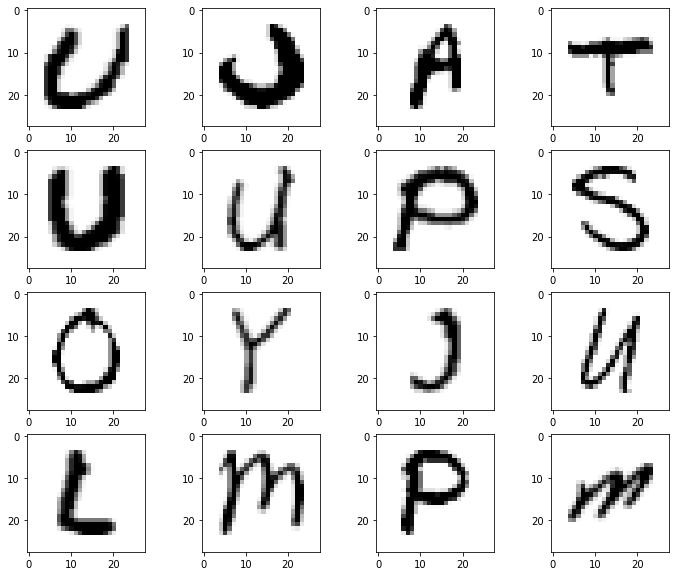

In [10]:
data_shuffle = shuffle(X)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(data_shuffle.iloc[i].values.reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

### Feature engineering

### Discriminator Training

In [18]:
import tensorflow as tf
from tensorflow.python.keras import layers

In [23]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [20]:

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
discriminator = make_discriminator_model()

W0702 17:49:20.945566 4697171392 deprecation.py:506] From /Users/vilhjamurr.vilhjalmsson/Desktop/Projects/GAN_pipe/venv/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))